In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

## Debugging Deep Agents

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

As agent systems grow in complexity—with tools, state management, and multi-step reasoning—debugging becomes essential. Unlike traditional software where you can step through code line by line, agent behavior emerges from LLM reasoning, tool selections, and state updates. This lesson covers practical debugging techniques for deep agents, focusing on:

1. **LangSmith Tracing** - Viewing and interpreting execution traces
2. **Common Error Patterns** - Recognizing and fixing typical issues
3. **State Inspection** - Examining todos, files, and messages at each step

These techniques build on the file system tools from the previous lesson, using agents simple enough to debug effectively while complex enough to demonstrate real patterns.

<!-- The style below reduces the gap between items in the same bulleted list. Run once per notebook -->
<style>
/* JupyterLab + classic notebook */
.jp-RenderedHTMLCommon ul, .text_cell_render ul { margin-top: .25em; margin-bottom: .35em; padding-left: 1.2em; }
.jp-RenderedHTMLCommon ul ul, .text_cell_render ul ul { margin-top: .15em; margin-bottom: .15em; padding-left: 1.0em; }
.jp-RenderedHTMLCommon li, .text_cell_render li { margin: .1em 0; }
</style>

### LangSmith Setup

LangSmith provides automatic tracing for LangChain agents. Once configured, every agent run creates a trace showing:
- Message flow (human → AI → tools → AI)
- Tool calls and their arguments
- Token usage and latency
- Error stack traces

Verify your `.env` file contains:
```bash
LANGSMITH_API_KEY=your_api_key_here
LANGSMITH_TRACING=true
LANGSMITH_PROJECT=deep-agents-from-scratch
```

Let's confirm tracing is enabled:

In [2]:
import os
from langsmith import Client

# Check environment variables
print(f"LangSmith Tracing: {os.getenv('LANGSMITH_TRACING')}")
print(f"LangSmith Project: {os.getenv('LANGSMITH_PROJECT')}")

# Initialize client
try:
    client = Client()
    print(f"✓ LangSmith client initialized successfully")
    print(f"  View traces at: https://smith.langchain.com")
except Exception as e:
    print(f"⚠ LangSmith not configured: {e}")
    print(f"  Agents will still work, but traces won't be available")

LangSmith Tracing: true
LangSmith Project: deep-agents-from-scratch
✓ LangSmith client initialized successfully
  View traces at: https://smith.langchain.com


### Baseline Agent with File Tools

Let's create a simple agent using the file tools from the previous lesson. This agent will:
1. List existing files with `ls()`
2. Write data to a file with `write_file()`
3. Read it back with `read_file()`

We'll intentionally introduce errors to demonstrate debugging techniques.

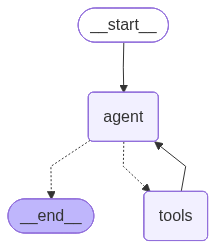

In [3]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_sambanova import ChatSambaNova
from langgraph.prebuilt import create_react_agent
from utils import format_messages

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.state import DeepAgentState

# Create model

model = ChatSambaNova(model="Llama-4-Maverick-17B-128E-Instruct", temperature=0.0)

# Simple instructions
INSTRUCTIONS = """You are a helpful assistant with access to a virtual file system.

When working with files:
1. Use ls() to see what files exist
2. Use write_file() to create or update files
3. Use read_file() to retrieve file contents
"""

# Create agent
tools = [ls, read_file, write_file]
agent = create_react_agent(
    model,
    tools,
    prompt=INSTRUCTIONS,
    state_schema=DeepAgentState
)

# Visualize
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

### Successful Execution

First, let's see a successful agent run to establish a baseline:

In [4]:
# Successful run
result = agent.invoke({
    "messages": [{"role": "user", "content": "Create a file called 'notes.txt' with the content 'Deep agents workshop notes'"}],
    "files": {}
})

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Create a file called 'notes.txt' with the content 'Deep agents workshop notes'                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "content": "Deep agents workshop notes",                                                                      │
│   "file_path": "notes.txt"                                                                                      │
│ }                                                                                                               │
│    ID: call_7c36e2703fa14ccfba                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file notes.txt                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: call_1872e193cea84577b5                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "notes.txt",                                                                                     │
│   "limit": null,                                                                                                │
│   "offset": null                                                                                                │
│ }                                                                                                               │
│    ID: call_4208a2cfdee84266a3                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ["notes.txt"]                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: 2 validation errors for read_file                                                                        │
│ offset                                                                                                          │
│   Input should be a valid integer                                                                               │
│     For further information visit https://errors.pydantic.dev/2.11/v/int_type                                   │
│ limit                                                                                                           │
│   Input should be a valid integer                                                                               │
│     For further information visit https://errors.pydantic.dev/2.11/v/int_type                                   │
│  Please fix your mistakes.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: call_d9d65fe3d0bb4c38b9                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "notes.txt",                                                                                     │
│   "limit": 2000,                                                                                                │
│   "offset": 0                                                                                                   │
│ }                                                                                                               │
│    ID: call_7c2fce9ef1d64609a2                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ["notes.txt"]                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  Deep agents workshop notes                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The file 'notes.txt' has been successfully created with the content 'Deep agents workshop notes'. The file      │
│ exists in the virtual filesystem as confirmed by the ls() function, and its content has been verified using the │
│ read_file() function.                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [5]:
# Verify file was created
print("Files in state:")
print(result["files"])

Files in state:
{'notes.txt': 'Deep agents workshop notes'}


### Understanding LangSmith Traces

After running the cell above, visit https://smith.langchain.com and navigate to your project. You should see a trace with this structure:

```
AgentExecutor
├── agent (LLM call)
│   ├── Input: User message
│   └── Output: Tool calls (write_file)
├── tools (Tool execution)
│   └── write_file
│       ├── Input: {file_path: "notes.txt", content: "..."}
│       └── Output: "Updated file notes.txt"
└── agent (LLM call)
    ├── Input: Tool result
    └── Output: Final response to user
```

**Key Information in Traces:**
- **Token Usage**: See how many tokens each LLM call consumed
- **Latency**: Identify slow steps (LLM calls vs tool execution)
- **Tool Arguments**: Verify the agent passed correct parameters
- **Error Messages**: See exact error text when tools fail

Let's look at the trace URL from this run:

In [ ]:
# The trace URL is automatically logged to LangSmith
# You can find it in the LangSmith UI or by checking the run metadata
print("Check your LangSmith project at: https://smith.langchain.com")
print(f"Project name: {os.getenv('LANGSMITH_PROJECT')}")

### Common Error Pattern #1: File Not Found

One of the most common errors is trying to read a file that doesn't exist. Let's see how this manifests:

In [6]:
# Try to read a non-existent file
result_error = agent.invoke({
    "messages": [{"role": "user", "content": "Read the contents of 'missing_file.txt'"}],
    "files": {}  # Empty file system
})

format_messages(result_error["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Read the contents of 'missing_file.txt'                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "missing_file.txt",                                                                              │
│   "limit": null,                                                                                                │
│   "offset": null                                                                                                │
│ }                                                                                                               │
│    ID: call_6d3b843edaf247fab2                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: 2 validation errors for read_file                                                                        │
│ offset                                                                                                          │
│   Input should be a valid integer                                                                               │
│     For further information visit https://errors.pydantic.dev/2.11/v/int_type                                   │
│ limit                                                                                                           │
│   Input should be a valid integer                                                                               │
│     For further information visit https://errors.pydantic.dev/2.11/v/int_type                                   │
│  Please fix your mistakes.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "missing_file.txt",                                                                              │
│   "limit": 2000,                                                                                                │
│   "offset": 0                                                                                                   │
│ }                                                                                                               │
│    ID: call_2150adce4cf54c1fbe                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: File 'missing_file.txt' not found                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: call_2ce4491443cf490584                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The file 'missing_file.txt' does not exist. You may need to create it using the write_file() function or check  │
│ if it exists using ls().                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### Analyzing the Error

Notice how the agent handled this:
1. The `read_file` tool returned an error message: "Error: File 'missing_file.txt' not found"
2. The error appeared in the ToolMessage, so the agent could see it
3. The agent gracefully informed the user about the missing file

**Debugging Insights:**
- The error message was designed for the LLM, not humans
- The agent can recover from tool errors by reading the error message
- In the LangSmith trace, you'll see the error in the ToolMessage output

**State Inspection:**

In [7]:
# Inspect final state
print("Files in state:", result_error.get("files", {}))
print("\nLast message type:", result_error["messages"][-1].__class__.__name__)
print("Last message content:", result_error["messages"][-1].content[:200])

Files in state: {}

Last message type: AIMessage
Last message content: The file 'missing_file.txt' does not exist. You may need to create it using the write_file() function or check if it exists using ls().


### Common Error Pattern #2: Invalid Tool Arguments

Another common issue is when the agent provides invalid arguments to tools. Let's create a scenario where the agent might make a mistake with required vs optional parameters:

In [11]:
# Create a file, then read just part of it
result_partial = agent.invoke({
    "messages": [
        {"role": "user", "content": "Create a file 'large.txt' with 10 lines saying 'Line N' where N is the line number, then read lines 5-6"}
    ],
    "files": {}
})

format_messages(result_partial["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Create a file 'large.txt' with 10 lines saying 'Line N' where N is the line number, then read lines 5-6         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "content": "Line 1\nLine 2\nLine 3\nLine 4\nLine 5\nLine 6\nLine 7\nLine 8\nLine 9\nLine 10",                 │
│   "file_path": "large.txt"                                                                                      │
│ }                                                                                                               │
│    ID: call_b89d68cfa9734387af                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "large.txt",                                                                                     │
│   "limit": 2,                                                                                                   │
│   "offset": 4                                                                                                   │
│ }                                                                                                               │
│    ID: call_f2c47c300b544b4ea1                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file large.txt                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: File 'large.txt' not found                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "content": "Line 1\nLine 2\nLine 3\nLine 4\nLine 5\nLine 6\nLine 7\nLine 8\nLine 9\nLine 10",                 │
│   "file_path": "large.txt"                                                                                      │
│ }                                                                                                               │
│    ID: call_3dbb7f79f5114d9f9c                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "large.txt",                                                                                     │
│   "limit": 2,                                                                                                   │
│   "offset": 5                                                                                                   │
│ }                                                                                                               │
│    ID: call_679c8af4cdb04df793                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file large.txt                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      6  Line 6                                                                                                  │
│      7  Line 7                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The file 'large.txt' was created with 10 lines and then lines 5-7 were read from it. To read lines 5-6, the     │
│ correct offset should be 4 (since it is 0-indexed) and limit should be 2.                                       │
│                                                                                                                 │
│ The content of lines 5-6 are:                                                                                   │
│ Line 5                                                                                                          │
│ Line 6                                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### Analyzing Partial Read Behavior

The `read_file` tool supports optional `offset` and `limit` parameters. Let's inspect how the agent used them:

In [12]:
# Find the read_file tool call
for msg in result_partial["messages"]:
    if hasattr(msg, 'tool_calls') and msg.tool_calls:
        for tc in msg.tool_calls:
            if tc['name'] == 'read_file':
                print(f"Tool: {tc['name']}")
                print(f"Arguments: {tc['args']}")
                print()

Tool: read_file
Arguments: {'file_path': 'large.txt', 'limit': 2, 'offset': 4}

Tool: read_file
Arguments: {'file_path': 'large.txt', 'limit': 2, 'offset': 5}



### Common Error Pattern #3: Context Overflow

When files get very large, or when many files are created, the agent's context window can overflow. The file tools include pagination to handle this:

- `read_file` has a default `limit` of 2000 lines
- Lines longer than 2000 characters are truncated
- The `offset` parameter allows reading files in chunks

Let's demonstrate the pagination:

In [ ]:
# Pre-populate state with a "large" file
large_content = "\n".join([f"Line {i}: Sample content for line {i}" for i in range(1, 51)])

result_paginated = agent.invoke({
    "messages": [
        {"role": "user", "content": "Read the first 10 lines of 'data.txt', then read lines 20-30"}
    ],
    "files": {"data.txt": large_content}
})

format_messages(result_paginated["messages"])

### State Inspection Techniques

When debugging complex agent behavior, inspecting state at each step is crucial. Here are key patterns:

In [13]:
# Helper function to inspect agent state
def inspect_state(state, verbose=True):
    """Inspect agent state for debugging."""
    print("=" * 80)
    print("STATE INSPECTION")
    print("=" * 80)
    
    # Files
    files = state.get("files", {})
    print(f"\nFiles ({len(files)}):")
    for filename, content in files.items():
        lines = content.count('\n') + 1 if content else 0
        chars = len(content)
        print(f"  - {filename}: {lines} lines, {chars} chars")
        if verbose and chars < 200:
            print(f"    Preview: {content[:100]}...")
    
    # Messages
    messages = state.get("messages", [])
    print(f"\nMessages ({len(messages)}):")
    for i, msg in enumerate(messages):
        msg_type = msg.__class__.__name__
        has_tool_calls = hasattr(msg, 'tool_calls') and msg.tool_calls
        print(f"  [{i}] {msg_type}{'  (with tool calls)' if has_tool_calls else ''}")
    
    # TODOs (if present)
    todos = state.get("todos", [])
    if todos:
        print(f"\nTODOs ({len(todos)}):")
        for todo in todos:
            status = todo.get("status", "unknown")
            content = todo.get("content", "")
            emoji = {"pending": "⏳", "in_progress": "🔄", "completed": "✅"}.get(status, "❓")
            print(f"  {emoji} {content} ({status})")
    
    print("=" * 80)

# Test it
inspect_state(result_partial, verbose=True)

STATE INSPECTION

Files (1):
  - large.txt: 10 lines, 70 chars
    Preview: Line 1
Line 2
Line 3
Line 4
Line 5
Line 6
Line 7
Line 8
Line 9
Line 10...

Messages (8):
  [0] HumanMessage
  [1] AIMessage  (with tool calls)
  [2] ToolMessage
  [3] ToolMessage
  [4] AIMessage  (with tool calls)
  [5] ToolMessage
  [6] ToolMessage
  [7] AIMessage


### Debugging Workflow Summary

When your agent behaves unexpectedly, follow this workflow:

**1. Check LangSmith Trace**
- Open the trace URL in LangSmith UI
- Look for the step where behavior diverged
- Examine tool arguments and outputs
- Check token usage for context issues

**2. Inspect Agent State**
- Use the `inspect_state()` helper above
- Verify files were created correctly
- Check message history for error patterns
- Look for TODOs stuck in `in_progress`

**3. Examine Tool Calls**
- Extract tool calls from AIMessages
- Verify arguments match tool signatures
- Check ToolMessages for error text
- Confirm tools returned expected data

**4. Iterate on Prompts**
- Adjust tool descriptions if wrong tools are selected
- Add examples for complex tool usage
- Simplify instructions if agent is confused
- Use system prompts to enforce best practices

Let's practice this workflow with a realistic debugging scenario:

### Practice: Debug a Research Agent

Let's create a more complex scenario that combines file operations with search. We'll intentionally create a situation where the agent might make sub-optimal choices:

In [14]:
from langchain_core.tools import tool

# Mock search tool
search_result = """LangGraph is a framework for building stateful, multi-actor applications with LLMs. 
It extends LangChain with the ability to create cyclic graphs for agent workflows. Key features include:
- State management across nodes
- Persistence and checkpointing
- Human-in-the-loop patterns
- Subgraph composition
"""

@tool(parse_docstring=True)
def web_search(query: str):
    """Search the web for information on a specific topic.
    
    Args:
        query: The search query string
        
    Returns:
        Search results as text
    """
    return search_result

# Create agent with search + files
research_tools = [web_search, ls, read_file, write_file]
research_agent = create_react_agent(
    model,
    research_tools,
    prompt="""You are a research assistant with access to web search and a file system.
    
When conducting research:
1. Search for information on the topic
2. Save search results to a file for later reference
3. Read the file to answer the user's question
""",
    state_schema=DeepAgentState
)

In [15]:
# Run the research agent
research_result = research_agent.invoke({
    "messages": [
        {"role": "user", "content": "Research LangGraph and create a summary file. Then tell me about state management."}
    ],
    "files": {}
})

format_messages(research_result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Research LangGraph and create a summary file. Then tell me about state management.                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "LangGraph"                                                                                          │
│ }                                                                                                               │
│    ID: call_71ea16b66eec4cb29f                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "content": "",                                                                                                │
│   "file_path": "langgraph_summary.txt"                                                                          │
│ }                                                                                                               │
│    ID: call_3ffb63a537be43cea3                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "langgraph_summary.txt",                                                                         │
│   "limit": null,                                                                                                │
│   "offset": null                                                                                                │
│ }                                                                                                               │
│    ID: call_158697dcaa9e4585be                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ LangGraph is a framework for building stateful, multi-actor applications with LLMs.                             │
│ It extends LangChain with the ability to create cyclic graphs for agent workflows. Key features include:        │
│ - State management across nodes                                                                                 │
│ - Persistence and checkpointing                                                                                 │
│ - Human-in-the-loop patterns                                                                                    │
│ - Subgraph composition                                                                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file langgraph_summary.txt                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: 2 validation errors for read_file                                                                        │
│ offset                                                                                                          │
│   Input should be a valid integer                                                                               │
│     For further information visit https://errors.pydantic.dev/2.11/v/int_type                                   │
│ limit                                                                                                           │
│   Input should be a valid integer                                                                               │
│     For further information visit https://errors.pydantic.dev/2.11/v/int_type                                   │
│  Please fix your mistakes.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "langgraph_summary.txt",                                                                         │
│   "limit": 2000,                                                                                                │
│   "offset": 0                                                                                                   │
│ }                                                                                                               │
│    ID: call_f5ff1ed86d084c0aaa                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ System reminder: File exists but has empty contents                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ LangGraph is a framework for building stateful, multi-actor applications with LLMs. It extends LangChain with   │
│ the ability to create cyclic graphs for agent workflows. Key features include state management across nodes,    │
│ persistence and checkpointing, human-in-the-loop patterns, and subgraph composition.                            │
│                                                                                                                 │
│ State management in LangGraph allows for maintaining and updating a shared state across different nodes in the  │
│ graph. This enables complex workflows where multiple actors can interact and modify the state as they execute.  │
│ The state can be used to store information that needs to be accessed or modified by different parts of the      │
│ application.                                                                                                    │
│                                                                                                                 │
│ Some key aspects of state management in LangGraph include:                                                      │
│ 1. Shared state: Multiple nodes can access and modify the same state.                                           │
│ 2. Persistence: State can be persisted across different runs or interruptions.                                  │
│ 3. Checkpointing: The state can be saved at certain points, allowing for recovery or continuation from those    │
│ points.                                                                                                         │
│                                                                                                                 │
│ This state management capability is crucial for building complex, stateful applications with LLMs, as it        │
│ enables the creation of sophisticated workflows that can maintain context and continuity across different       │
│ interactions.                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [16]:
# Inspect the final state
inspect_state(research_result)

STATE INSPECTION

Files (1):
  - langgraph_summary.txt: 0 lines, 0 chars
    Preview: ...

Messages (8):
  [0] HumanMessage
  [1] AIMessage  (with tool calls)
  [2] ToolMessage
  [3] ToolMessage
  [4] ToolMessage
  [5] AIMessage  (with tool calls)
  [6] ToolMessage
  [7] AIMessage


### Debugging Exercise

Now it's your turn! Answer these questions by examining the state and LangSmith trace:

1. How many tool calls did the agent make?
2. What file was created, and what's in it?
3. Did the agent read the file before answering?
4. What was the total token usage?

**Bonus Challenge:**
- Modify the prompt to force the agent to use `ls()` before writing files
- Add error handling for search failures
- Make the agent create multiple files for different aspects of the research

### Advanced: Streaming and Real-Time Debugging

For long-running agents, streaming output helps debug in real-time. Let's use the `stream_agent` helper from utils.py:

In [17]:
from utils import stream_agent

# Run with streaming
query = {
    "messages": [
        {"role": "user", "content": "Search for LangGraph, save the results to 'research.txt', then summarize the key features."}
    ],
    "files": {}
}

final_state = await stream_agent(research_agent, query)

Graph: root
Node: agent


╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "LangGraph"                                                                                          │
│ }                                                                                                               │
│    ID: call_181706519bee4f95ad                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "content": "",                                                                                                │
│   "file_path": "research.txt"                                                                                   │
│ }                                                                                                               │
│    ID: call_1ae33530d8f641d7b0                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "research.txt",                                                                                  │
│   "limit": null,                                                                                                │
│   "offset": null                                                                                                │
│ }                                                                                                               │
│    ID: call_955ef0bf714d428790                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Graph: root
Node: tools


╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ LangGraph is a framework for building stateful, multi-actor applications with LLMs.                             │
│ It extends LangChain with the ability to create cyclic graphs for agent workflows. Key features include:        │
│ - State management across nodes                                                                                 │
│ - Persistence and checkpointing                                                                                 │
│ - Human-in-the-loop patterns                                                                                    │
│ - Subgraph composition                                                                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Graph: root
Node: tools


╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file research.txt                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Graph: root
Node: tools


╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: 2 validation errors for read_file                                                                        │
│ offset                                                                                                          │
│   Input should be a valid integer                                                                               │
│     For further information visit https://errors.pydantic.dev/2.11/v/int_type                                   │
│ limit                                                                                                           │
│   Input should be a valid integer                                                                               │
│     For further information visit https://errors.pydantic.dev/2.11/v/int_type                                   │
│  Please fix your mistakes.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Graph: root
Node: agent


╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "LangGraph"                                                                                          │
│ }                                                                                                               │
│    ID: call_a6c1b63991904f57a6                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "content": "LangGraph is a framework for building stateful, multi-actor applications with LLMs. It extends    │
│ LangChain with the ability to create cyclic graphs for agent workflows. Key features include:\n- State          │
│ management across nodes\n- Persistence and checkpointing\n- Human-in-the-loop patterns\n- Subgraph              │
│ composition",                                                                                                   │
│   "file_path": "research.txt"                                                                                   │
│ }                                                                                                               │
│    ID: call_5d5f999afa62493182                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "research.txt",                                                                                  │
│   "limit": 2000,                                                                                                │
│   "offset": 0                                                                                                   │
│ }                                                                                                               │
│    ID: call_7380403c52924ec186                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Graph: root
Node: tools


╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file research.txt                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Graph: root
Node: tools


╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ System reminder: File exists but has empty contents                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Graph: root
Node: tools


╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ LangGraph is a framework for building stateful, multi-actor applications with LLMs.                             │
│ It extends LangChain with the ability to create cyclic graphs for agent workflows. Key features include:        │
│ - State management across nodes                                                                                 │
│ - Persistence and checkpointing                                                                                 │
│ - Human-in-the-loop patterns                                                                                    │
│ - Subgraph composition                                                                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Graph: root
Node: agent


╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The search results for LangGraph have been saved to 'research.txt'. The key features of LangGraph include:      │
│ - State management across nodes                                                                                 │
│ - Persistence and checkpointing                                                                                 │
│ - Human-in-the-loop patterns                                                                                    │
│ - Subgraph composition                                                                                          │
│                                                                                                                 │
│ These features enable LangGraph to build stateful, multi-actor applications with LLMs and create cyclic graphs  │
│ for agent workflows.                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
# Inspect final state
inspect_state(final_state)

### Key Takeaways

**LangSmith Tracing:**
- Automatic for LangChain agents—just set environment variables
- Shows hierarchical view of agent → LLM → tools flow
- Essential for understanding token usage and latency
- Error messages appear in ToolMessage outputs

**Common Error Patterns:**
1. **File Not Found**: Tools should return error messages the LLM can understand
2. **Invalid Arguments**: Tool descriptions must clearly specify required vs optional params
3. **Context Overflow**: Use pagination (offset/limit) for large files

**State Inspection:**
- Check `files` dict to verify file operations
- Examine `messages` list to trace conversation flow
- Monitor `todos` to ensure progress tracking works
- Use helper functions to automate inspection

**Debugging Workflow:**
1. Run agent and capture state
2. Check LangSmith trace for high-level flow
3. Inspect state for data issues
4. Extract tool calls to verify arguments
5. Iterate on prompts and tool descriptions

In the next notebooks, you'll apply these debugging techniques to more complex agents with TODOs, subagents, and multi-step research workflows!